In [74]:
import dicom
import os.path
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
MAIN_FOLDER = "sample_images"
#MAIN_FOLDER = "stage1/stage1"
SCALE_CONST = 16
hyper_param = 0.001
patient_id_list = [name for name in os.listdir(MAIN_FOLDER)]

def compute_score(labels,pred):
	error_count = 0
	for tup in zip(pred,labels):
		if tup[0]!=tup[1]:
			error_count+=1
	return float(labels.shape[0]-error_count)/float(labels.shape[0])

def LDA_predict(cov,x_list,pi_list,mean_list):
    inv_cov = np.linalg.pinv(cov+hyper_param*np.identity(cov.shape[0]))
    log_det = sum([math.log(eig+hyper_param) for eig in np.linalg.eigvals(cov)])
    pred = []
    for x in x_list:
        estimated_g = []
        for i in range(len(mean_list)):
            estimated_g.append(-0.5*np.dot(np.dot((x-mean_list[i]).T,inv_cov),(x-mean_list[i]))+math.log(pi_list[i])-0.5*log_det)
            #estimated_g.append(np.dot(np.dot(x.T,inv_cov),mean_list[i])-0.5*np.dot(np.dot(mean_list[i].T,inv_cov),mean_list[i])+math.log(pi_list[i]))
        pred.append(np.argmax(estimated_g))
    return pred

def QDA_predict(cov_list,x_list,pi_list,mean_list):
    pred = []
    inv_cov_list = [np.linalg.pinv(cov_list[i]+hyper_param*np.identity(cov_list[i].shape[0])) for i in range(len(mean_list))]
    eigvals = np.linalg.eigvals(cov_list[i])
    log_det_list = [sum([math.log(eig+hyper_param) for eig in eigvals]) for i in range(len(mean_list))]
    
    for x in x_list:
        estimated_g = []
        for i in range(len(mean_list)):
            inv_cov = inv_cov_list[i]
            estimated_g.append(-0.5*np.dot(np.dot((x-mean_list[i]).T,inv_cov),(x-mean_list[i]))+math.log(pi_list[i])-0.5*(log_det_list[i]))
        pred.append(np.argmax(estimated_g))
    return pred
#print patient_id_list
#df_labels = pd.read_csv("stage1_labels.csv")
#df_labels = df_labels.drop('index')
#print df_labels[(df_labels['id']=='0015ceb851d7251b8f399e39779d1e7d')].loc[:,'cancer']
label_list = {}
with open("stage1_labels.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row[1]=='0' or row[1]=='1':
            label_list[row[0]]=int(row[1])
test_set = []
with open("stage1_sample_submission.csv") as csvfile:
    reader = csv.reader(csvfile,delimiter=',')
    for row in reader:
        if row[0]!='id':
            test_set.append(row[0])

In [75]:
mid_images = []
for patient_id in patient_id_list:
    if patient_id not in test_set:
        files = [f for f in os.listdir(MAIN_FOLDER+"/"+patient_id) if os.path.isfile(os.path.join(MAIN_FOLDER+"/"+patient_id, f))]
        num_files = len(files)
        image = dicom.read_file(MAIN_FOLDER+"/"+patient_id+"/"+files[num_files//2])
        image_features = [np.mean([image.pixel_array[SCALE_CONST*i+i2][SCALE_CONST*j+j2] for j2 in range(SCALE_CONST) for i2 in range(SCALE_CONST)]) for j in range(image.Columns/SCALE_CONST) for i in range(image.Rows/SCALE_CONST)]
        #mid_images[patient_id] = image_features
        image_features.append(label_list[patient_id]) #last column is of labels
        mid_images.append(image_features)

C:\Users\Yong-Chan\Anaconda2_62bit\lib\site-packages\ipykernel\__main__.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Yong-Chan\Anaconda2_62bit\lib\site-packages\ipykernel\__main__.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


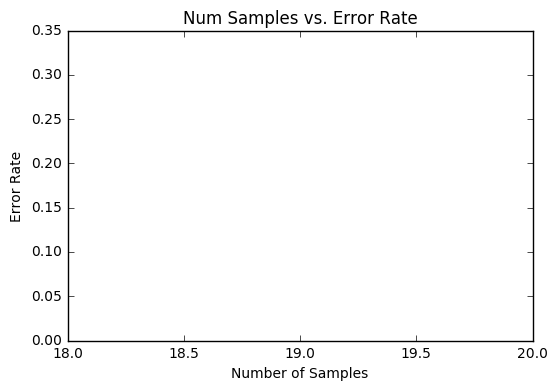

LDA errors: [0.33333333333333337]
QDA_errors: [0.0]


In [77]:
validation_set = np.array(mid_images[:len(mid_images)//5])
training_set = np.array(mid_images[len(mid_images)//5:])
nums_samples = [len(mid_images)]
LDA_errors = []
QDA_errors = []
classes = []
for label in training_set[:,training_set.shape[1]-1]:
	if label not in classes:
		classes.append(label)
num_classes = len(classes)
#nums_samples = [100,200,500,1000,len(mid_images)]
for num_samples in nums_samples:
    v_set = validation_set[:,:validation_set.shape[1]-1]
    v_label = validation_set[:,validation_set.shape[1]-1]
    t_set = training_set[:num_samples,:training_set.shape[1]-1]
    t_label = training_set[:num_samples,training_set.shape[1]-1]
    classes = [[] for _ in range(num_classes)]
    classes_means = []
    classes_covs = []
    for i in range(len(t_label)):
        classes[int(t_label[i])].append(t_set[i])
    for class_label in classes:
        class_label = np.array(class_label)
        classes_means.append(np.mean(class_label,axis=0))
        classes_covs.append(np.cov(class_label.T))
    mean_cov = np.array([[0 for _ in range(t_set.shape[1])] for _ in range(t_set.shape[1])])
    for cov in classes_covs:
        mean_cov = mean_cov+cov
    mean_cov = mean_cov/float(num_classes)
    pi_list = [float(len(class_label))/float(t_set.shape[0]) for class_label in classes]
    LDA_pred = LDA_predict(mean_cov,v_set,pi_list,classes_means)
    QDA_pred = QDA_predict(classes_covs,v_set,pi_list,classes_means)
    LDA_score = compute_score(v_label,LDA_pred)
    QDA_score = compute_score(v_label,QDA_pred)
    LDA_errors.append(1.0-LDA_score)
    QDA_errors.append(1.0-QDA_score)
plt.plot(nums_samples,LDA_errors,'r-',label='LDA error')
plt.plot(nums_samples,QDA_errors,'b-',label='QDA error')
plt.title('Num Samples vs. Error Rate')
plt.xlabel('Number of Samples')
plt.ylabel('Error Rate')
plt.show()
print "LDA errors:",LDA_errors
print "QDA_errors:",QDA_errors